## Inference on an out-of-sample input

To make sure our model actually learned, we'll want to test it on data that it never saw in training or evaluation. I grabbed a big [PGN file](http://pgnmentor.com/players/Paehtz.zip) with a bunch of new chess games from the web, then processed them in the same way as the training data to create 100x100 grayscale images of chess boards. (In particular I ran the *generate_data.py* file with a few tweaks (to paths) and the *./flatten.sh* file to remove their color and alpha channels.

We'll see if the model can recognize these new images.

In [1]:
import tensorflow as tf
from model import Model
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We'll want to confirm that these boards actually weren't part of our data set. Since the board configuration itself is encoded in the file path, we'll just check to see that the file path for these new games doesn't appear anywhere in our existing data directories:

In [2]:
import glob
imgs = glob.glob("out_of_sample_data/*.png")

def is_out_of_sample(filename):
    path = imgs[0].split("/")[1]
    return len(glob.glob("data/*/%s" %(path))) == 0

out_of_sample_imgs = [i for i in imgs if is_out_of_sample(i)]
len(out_of_sample_imgs)

2532

We'll convert the images into a Tensorflow-compatible format, normalizing the pixel values from -1 to 1 in exactly the way we did with our training data:

In [4]:
path_to_image_files[0]

'out_of_sample_data/4q3-n1r1n2k-1pp1prpp-p4p2-2BP1N2-P3PP2-1P3PRP-1Q4RK.png'

In [5]:
path_to_image_files = out_of_sample_imgs[:10]
images = []
for path_to_image_file in path_to_image_files:
    image = tf.image.decode_png(tf.read_file(path_to_image_file), channels=1)
    image = tf.reshape(image, [100, 100, 1])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.multiply(tf.subtract(image, 0.5), 2)
    images.append(image)
images = tf.stack(images)

Here we actually do the inference. Notice how `Model` takes in some images and spits out predictions about what the pieces are. `pieces_logits` is a tensor with shape `(10, 64, 13)` where 10 is the number of images we gave it, 64 is the number of squares on a chessboard, and 13 is the number of possible options for what can go on each square (6 piece types, one for each color, plus an empty square).

In [6]:
pieces_logits = Model.inference(images, drop_rate=0.0)
pieces_predictions = tf.argmax(pieces_logits, axis=2)
pieces_predictions_string = tf.reduce_join(tf.as_string(pieces_predictions), axis=0)

In [7]:
pieces_logits

<tf.Tensor 'stack_2:0' shape=(10, 64, 13) dtype=float32>

In [8]:
sess = tf.InteractiveSession()

The following "restores" the model to the checkpoint after training. If we didn't do this, the model would be in its initial state and would not give good predictions.

In [9]:
restorer = tf.train.Saver()
checkpoint_path = tf.train.latest_checkpoint('logs/train')
restorer.restore(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from logs/train/latest.ckpt


In [10]:
pieces_predictions_val, pieces_predictions_string_val, images_val = sess.run([pieces_predictions, pieces_predictions_string, images])
images_val = (images_val / 2.0) + 0.5

In [11]:
def board(arr):
    labels = { 'k': 1, 'q': 2, 'r': 3, 'b': 4, 'n': 5, 'p': 6, 'K': 7, 'Q': 8, 'R': 9, 'B': 10, 'N': 11, 'P': 12, 'X': 0 }
    labels = {v: k for k, v in labels.iteritems()}

    xs = [labels[l] for l in arr]
    s = ""
    for i in range(len(xs)):
        if i % 8 == 0:
            print "".join(list(reversed(list(s))))
            s = ""
        s += xs[i]
    print "".join(list(reversed(list(s))))

Let's look at what the model has predicted for our first board. First we'll look at the encoded representation, a size-64 vector where each element is a number from 0 to 12 saying which of the 13 pieces (or an empty piece) is on our square:

In [12]:
pieces_predictions_val[0]

array([ 0,  0,  0,  2,  0,  0,  0,  0,  1,  0,  0,  5,  0,  3,  0,  5,  6,
        6,  3,  6,  0,  6,  6,  0,  0,  0,  6,  0,  0,  0,  0,  6,  0,  0,
       11,  0, 12, 10,  0,  0,  0,  0, 12, 12,  0,  0,  0, 12, 12,  9, 12,
        0,  0,  0, 12,  0,  7,  9,  0,  0,  0,  0,  8,  0])

Our `board` function converts that raw representation into something that looks like a board. Black pieces are lowercase.

In [13]:
board(pieces_predictions_val[0])


XXXXqXXX
nXrXnXXk
XppXprpp
pXXXXpXX
XXBPXNXX
PXXXPPXX
XPXXXPRP
XQXXXXRK


Finally, we'll see what the actual board looks like:

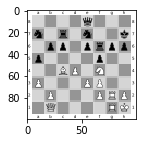

In [12]:
figure(figsize=(2, 2))
imshow(images_val[0].squeeze(), cmap="gray")

In [13]:
board(pieces_predictions_val[3])


rXXqXrkX
pppnXppp
XXbbpnXX
XXXXXXXX
XXXPXXXX
XXPBXNXX
PPXNXPPP
RXBQRXKX


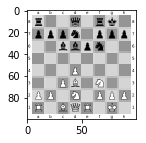

In [14]:
figure(figsize=(2, 2))
imshow(images_val[3].squeeze(), cmap="gray")

In [15]:
sess.close()